In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hwk3-task1-spills.ipynb")

FileNotFoundError: [Errno 2] No such file or directory: 'hwk3-task1-spills.ipynb'

# Task 1: Visualizing oil spills in NY State

## Instructions

- First, update the following cell to have a link to *your* Homework 3 GitHub repository:

**UPDATE THIS LINK**
https://github.com/llumj/eds220-hwk3-Muill


- Review the [complete rubric for this task](https://docs.google.com/document/d/1Ce4EO3MEHW5uLks4x8BECWlkim2bcmxB4f8Qo4z26z8/edit?usp=sharing) before starting.

- **Meaningful commits should be made every time you finish a major step.** We'll check your repository and view the commit history.

- Comment mindfully in a way that enriches your code. Comments should follow best practices.

- **Do not update the top cell with the `otter` import**, this is used internally for grading.

- Delete all the comments initially included in this notebook (ex: `# Your code here`).


## About the data
In this task you will use two datsets:

### First dataset: oil spills data

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
You can find extra information and metadata for this dataset in the `NYSDEC_SpillIncidents_Overview.pdf` and `NYSDEC_SpillIncidents_DataDictionary.pdf` documents available at the portal.

### Second dataset: TIGER shapefile

The second dataset is the [the 2023 Counties (and equivalent) TIGER shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341) from the Census Bureau. You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 


## 1. File management
a. Create a `data/` directory inside your `eds220-hwk3` directory. If you download any data, it should be transferred into this folder. 

b. Add the `data/` directory to your `.gitignore` file and push your changes. This is IMPORTANT: the datasets we'll be working with are large and they will most likely jam your `git` workflow if you try to push them. Your `data/` directory should not be in your GitHub repository.

## 2. Datasets description
Read the metadata for both datsets and write a description about each one. Indicate the date sources and date of access.


Shape files are digital representations of geographical features. In this case, we are working with county lines for the United States. 

The second file contains spills across new york state. It has has the start date, end date and types hazard that was spilled. 

## Complete Workflow

In [ ]:
# Complete Workflow 

# Import library
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# Read in the data
spills = pd.read_csv("data/Spill_Incidents_20241107.csv")
us_counties = gpd.read_file("data/tl_2023_us_county")

# Check the head of each variable 
spills.head()
us_counties.head()

# Check data types 
spills.dtypes
us_counties.dtypes

# Find unique values in Material Family series
spills["Material Family"].unique()

# d. Find unique values in County series
spills['County'].unique()

# a. Simplify column names in spills variable
spills.columns = spills.columns.str.strip().str.lower().str.replace(' ', '_') 

# Covert date columns to date time 
spills.spill_date = pd.to_datetime(spills.spill_date)
spills.close_date = pd.to_datetime(spills.close_date)

# Check
spills.dtypes

# Select data for spills that took place between 2023/01/01 and 2023/10/31
petr_23 = spills.loc[(spills['spill_date'] >= '2023/01/01') & (spills['close_date'] <= '2023/10/31')].copy()
petr_23.head()

# extract all the years and months to new columns 
petr_23['spill_year'] = petr_23['spill_date'].dt.year
petr_23['spill_month'] = petr_23['spill_date'].dt.month
petr_23['close_year'] = petr_23['close_date'].dt.year
petr_23['close_month'] = petr_23['close_date'].dt.month

# Check columns
petr_23.head()

# Verify and print the messages using f-strings 
if (petr_23['spill_year'] == 2023).any() or not (petr_23['spill_month'].between(1, 10).all() and petr_23['close_month'].between(1, 10).all()): 
    print(f'All records are from 2023, between January and October') 
else: 
    print(f'Some records are outside of year 2023')

# Create assertion # out for running purpose
#assert (petr_23['material_family'] == 'Petroleum').all(), "Some records are not 'Petroleum'"

# Find the number of spills by county 
spills_per_county = petr_23.groupby('county').size().reset_index(name='n_spills')
spills_per_county

# Check the crs of us_counties
us_counties.crs

# Simplify us_counties 
us_counties.columns = us_counties.columns.str.lower()

# Check us_counties varible 
us_counties.tail()

# Filter statefp for 36, the corresponding code for New York state 
ny_counties = us_counties.loc[us_counties['statefp'] == '36']

# ny_counties.plot()

# Find county names in spills_per_county but not in ny_counties
diff_names_spills = np.setdiff1d(spills_per_county['county'], ny_counties['name'])
diff_names_spills

# Find county names in ny_counties but not in spills_per_county
diff_names_ny = np.setdiff1d(ny_counties['name'],spills_per_county['county'])
diff_names_ny

# Number of spills on Tuscarora Reservation
spills_per_county.loc[spills_per_county['county'] == 'Tuscarora Indian Reservation']

# Update column name 
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

# Create assertion to check 
assert (spills_per_county['county'] == 'St. Lawrence').any(), 'Update Failed'

# Change column name before join
ny_counties = ny_counties.rename(columns = {'name' : 'county'})

# Inner join
ny_counties = pd.merge(ny_counties,
                       spills_per_county,
                       how='inner',
                       on='county')

# Add 1 to Niagara county
ny_counties.at[45, 'n_spills'] += 1

# Check 
ny_counties.loc[ny_counties['county'] == 'Niagara']

# Map
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
ny_counties.plot(
    ax=ax,
    column='n_spills',
    cmap='magma_r',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "New York Spills Per County",
        "orientation": "horizontal",
        "pad": 0.05
    }
)

# This map shows the number of spills by county in New York State. 
# The three counties with the most spills are Suffolk(657), Westchester(630), Nassau(503).

## 3. Import libraries

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## 4. Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties data as a variable named `counties`.

If you are using file paths to access the data, these should be constructed using the `os` package.

In [3]:
spills = pd.read_csv("data/Spill_Incidents_20241107.csv")
us_counties = gpd.read_file("data/tl_2023_us_county")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds220-env/share/proj failed


## 5. Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you information you will need to use in the next exercises.

### 5.A. Exploration

In the next cells:

a. Check the dataframe's head.

b. Check the data types of the columns.

c. Check the unique values in the `material_family` column.

d. Check the unique values in the `county` column.

You can add other cells for preliminary data exploration.

In [4]:
# Check the head of each variable 
spills.head()

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10.0,Gallons,0.0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,NaN,0.0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,Pounds,0.0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,08/02/2002,08/02/2002,Equipment Failure,NaN,Commercial/Industrial,10/28/2002,transformer oil,Petroleum,1.0,Gallons,0.0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,01/20/2003,01/20/2003,Traffic Accident,NaN,Commercial/Industrial,01/22/2003,transformer oil,Petroleum,6.0,Gallons,6.0


In [5]:
# Check data types 
spills.dtypes

Spill Number               int64
Program Facility Name     object
Street 1                  object
Street 2                  object
Locality                  object
County                    object
ZIP Code                  object
SWIS Code                  int64
DEC Region                 int64
Spill Date                object
Received Date             object
Contributing Factor       object
Waterbody                 object
Source                    object
Close Date                object
Material Name             object
Material Family           object
Quantity                 float64
Units                     object
Recovered                float64
dtype: object

In [6]:
# Find unique values in Material Family series
spills["Material Family"].unique()

array(['Other', 'Petroleum', 'Hazardous Material', 'Oxygenates'],
      dtype=object)

In [7]:
# d. Find unique values in County series
spills['County'].unique()

array(['Westchester', 'Queens', 'Bronx', 'Sullivan', 'Cortland',
       'New York', 'Ulster', 'Kings', 'Orange', 'Dutchess', 'Onondaga',
       'Saratoga', 'Cayuga', 'Oswego', 'Warren', 'Niagara', 'Rockland',
       'Nassau', 'Jefferson', 'Schenectady', 'Albany', 'Monroe',
       'Schuyler', 'St Lawrence', 'Richmond', 'Clinton', 'Lewis', 'Essex',
       'Chenango', 'Erie', 'Livingston', 'Wayne', 'Suffolk', 'Orleans',
       'Ontario', 'Genesee', 'Otsego', 'Tompkins', 'Madison', 'Chemung',
       'Seneca', 'Oneida', 'Broome', 'Hamilton', 'Washington', 'Franklin',
       'Columbia', 'Fulton', 'Herkimer', 'Schoharie', 'Rensselaer',
       'Montgomery', 'Putnam', 'Delaware', 'New Jersey - Region 2',
       'Steuben', 'Tioga', 'Chautauqua', 'Cattaraugus', 'Wyoming',
       'Yates', 'Greene', 'Pennsylvania - Region 9', 'Allegany',
       'New Jersey - Region 3 (N)', 'Cattaraugus Indian Reservation',
       'New Jersey - Region 3 (T)', 'Canada - Region 6',
       'Canada - Region 9', 'Pennsyl

<!-- BEGIN QUESTION -->

f. Use the next markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

<!-- END QUESTION -->

*Your answer here.*

I used head() to observe the first few rows of the data set. This allows me to see what values I am working with in each series. Looking up the data types allows me to see what type each value is. Looking at the unique values in material family I learned that there are 4 different categories. Looking at the unique values for county I noticed that there were values that were way longer than just a single county name. i.e. New Jersey - Region 3 (N)

### 5.B. Cleaning
a. Simplify column names as needed.

b. Update column data types as needed. If you're not sure if any data types are needed at this point, you may come back later to this cell.

In [8]:
# a. Simplify column names in spills variable
spills.columns = spills.columns.str.strip().str.lower().str.replace(' ', '_')

# Check spills variable
print(spills.head())

   spill_number program_facility_name                  street_1 street_2  \
0        107132                MH 864        RT 119/MILLWOOD RD      NaN   
1        405586             BOWRY BAY        WATER POLL CONTROL      NaN   
2        405586             BOWRY BAY        WATER POLL CONTROL      NaN   
3        204667            POLE 16091       GRACE AVE/BURKE AVE      NaN   
4        210559               POLE ON  FERDALE LOMIS RD / RT 52      NaN   

   locality       county zip_code  swis_code  dec_region  spill_date  \
0  ELMSFORD  Westchester      NaN       6000           3  10/10/2001   
1    QUEENS       Queens      NaN       4101           2  08/21/2004   
2    QUEENS       Queens      NaN       4101           2  08/21/2004   
3     BRONX        Bronx      NaN        301           2  08/02/2002   
4   LIBERTY     Sullivan      NaN       5336           3  01/20/2003   

  received_date contributing_factor   waterbody                 source  \
0    10/10/2001             Unknown 

In [9]:
# Covert date columns to date time 
spills.spill_date = pd.to_datetime(spills.spill_date)
spills.close_date = pd.to_datetime(spills.close_date)

# Check
print(spills.dtypes)

spill_number                      int64
program_facility_name            object
street_1                         object
street_2                         object
locality                         object
county                           object
zip_code                         object
swis_code                         int64
dec_region                        int64
spill_date               datetime64[ns]
received_date                    object
contributing_factor              object
waterbody                        object
source                           object
close_date               datetime64[ns]
material_name                    object
material_family                  object
quantity                        float64
units                            object
recovered                       float64
dtype: object


### 5.C. Data selection

a. Select data about petroleum spills that took place between January 1st 2023, and October 31st 2023 (including both dates). Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells as needed.

In [10]:
# Select data for spills that took place between 2023/01/01 and 2023/10/31
petr_23 = spills.loc[(spills['spill_date'] >= '2023/01/01') & (spills['close_date'] <= '2023/10/31')].copy()
petr_23.head()

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
147,2301651,(DRILL) TUGBOAT,2015 RICHMOND TERRACE,NaN,STATEN ISLAND,Richmond,NaN,4301,2,2023-05-30,05/30/2023,Other,NaN,Commercial/Industrial,2023-05-30,other - diesel,Other,0.0,Gallons,0.0
220,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,2023-07-12,diesel,Petroleum,0.0,NaN,0.0
221,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,2023-07-12,#2 fuel oil,Petroleum,0.0,Gallons,0.0
222,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,2023-07-12,gasoline,Petroleum,0.0,NaN,0.0
223,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,2023-07-12,kerosene [#1 fuel oil] (on-site consumption),Petroleum,0.0,NaN,0.0


<!-- BEGIN QUESTION -->

b. Use `print()` and f-strings to print messages verifying that `petr_23` only has data for 2023 and from January through October.
HINT: [pandas.Series.dt.year](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html) and [pandas.Series.dt.month](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html).

In [11]:
# extract all the years and months to new columns 
petr_23['spill_year'] = petr_23['spill_date'].dt.year
petr_23['spill_month'] = petr_23['spill_date'].dt.month
petr_23['close_year'] = petr_23['close_date'].dt.year
petr_23['close_month'] = petr_23['close_date'].dt.month

petr_23.head()


            
# Verify and print the messages using f-strings 
if (petr_23['spill_year'] == 2023).any() or not (petr_23['spill_month'].between(1, 10).all() and petr_23['close_month'].between(1, 10).all()): 
    print(f'All records are from 2023, between January and October') 
else: 
    print(f'Some records are outside of year 2023')

All records are from 2023, between January and October


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

c. Write tests using `assert` to verify that `petr_23` only has data for petroleum spills.

In [12]:
assert (petr_23['material_family'] == 'Petroleum').all(), "Some records are not 'Petroleum'"

AssertionError: Some records are not 'Petroleum'

<!-- END QUESTION -->

### 5.D. Data aggregation

Create new data frame named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Data frame has two columns only:
    - Column one: county names, column name = `county`
    - Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if needed.


In [13]:
# Your code here
spills_per_county = petr_23.groupby('county').size().reset_index(name='n_spills')
spills_per_county

,county,n_spills
0,Albany,149
1,Allegany,33
2,Bronx,132
3,Broome,65
4,Canada - Region 6,1
...,...,...
59,Washington,62
60,Wayne,34
61,Westchester,630
62,Wyoming,21


## 6. Prepare counties data

This section refers to the `counties` geo-dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### 6.A. Exploration

In the next cells:

a. Check the geo-dataframe's head.

b. Check the data types of the columns.

c. Check the geo-dataframe's CRS.

d. Plot the geo-dataframe.

You can add any other cells of preliminary data exploration.

In [14]:
us_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [15]:
# Check the data types of the columns 
us_counties.dtypes

STATEFP       object
COUNTYFP      object
COUNTYNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CSAFP         object
CBSAFP        object
METDIVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [16]:
# Check the crs 
us_counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

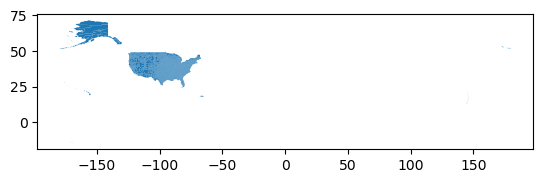

In [17]:
# Plot the data frame 
us_counties.plot()

<!-- BEGIN QUESTION -->

f. Use the next markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

*Your answer here.*

<!-- END QUESTION -->

### 6.B. Cleaning

Simplify column names as needed.

In [18]:
# Simplify us_counties 
us_counties.columns = us_counties.columns.str.lower()

# Check us_counties varible 
us_counties.tail()

,statefp,countyfp,countyns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry
3230,13,123,00351260,13123,0500000US13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103893380,12276629,+34.6905232,-084.4548113,"POLYGON ((-84.30237 34.57832, -84.30329 34.577..."
3231,27,135,00659513,27135,0500000US27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329782924,16924046,+48.7610683,-095.8215042,"POLYGON ((-95.25857 48.88666, -95.25707 48.885..."
3232,28,089,00695768,28089,0500000US28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1849790735,72085470,+32.6343703,-090.0341603,"POLYGON ((-90.14883 32.40026, -90.14890 32.400..."
3233,48,227,01383899,48227,0500000US48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039148,8841781,+32.3034298,-101.4387208,"POLYGON ((-101.18138 32.21252, -101.18138 32.2..."
3234,54,099,01550056,54099,0500000US54099,Wayne,Wayne County,06,H1,G4020,170,26580,None,A,1310547889,15816947,+38.1436416,-082.4226659,"POLYGON ((-82.30872 38.28106, -82.30874 38.280..."


### 6.C. Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them.

<Axes: >

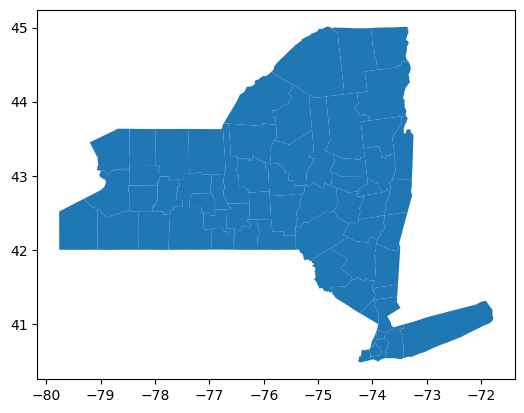

In [19]:
# Filter statefp for 36, the corresponding code for New York state 
ny_counties = us_counties.loc[us_counties['statefp'] == '36']

ny_counties.plot()

## 7 Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### 7.A. Explore data

In the next cells:

a. Print the names of counties in `ny_counties`, without repetition.

b. Print the names of counties in `spills_per_county`, without repetition. Examine the differences in the outputs.


In [20]:
# Print names in ny_counties without repetition
print(ny_counties['name'].unique())

['Steuben' 'Saratoga' 'Allegany' 'Oswego' 'Ulster' 'St. Lawrence'
 'Schuyler' 'Essex' 'Suffolk' 'Hamilton' 'Dutchess' 'Otsego' 'Tompkins'
 'Albany' 'Cayuga' 'Greene' 'Herkimer' 'Warren' 'Jefferson' 'Clinton'
 'Nassau' 'Madison' 'Washington' 'Westchester' 'Lewis' 'Ontario'
 'Cortland' 'Richmond' 'Erie' 'Putnam' 'Montgomery' 'Sullivan' 'Orleans'
 'Oneida' 'Cattaraugus' 'Yates' 'Tioga' 'Monroe' 'Schoharie' 'Broome'
 'Rensselaer' 'Seneca' 'Queens' 'Genesee' 'Wayne' 'Niagara' 'Kings'
 'Chemung' 'Wyoming' 'New York' 'Columbia' 'Chautauqua' 'Franklin'
 'Onondaga' 'Chenango' 'Fulton' 'Rockland' 'Livingston' 'Delaware'
 'Orange' 'Schenectady' 'Bronx']


In [21]:
# Print names in spills_per_county without repetition
print(spills_per_county['county'].unique())



['Albany' 'Allegany' 'Bronx' 'Broome' 'Canada - Region 6' 'Cattaraugus'
 'Cayuga' 'Chautauqua' 'Chemung' 'Chenango' 'Clinton' 'Columbia'
 'Cortland' 'Delaware' 'Dutchess' 'Erie' 'Essex' 'Franklin' 'Fulton'
 'Genesee' 'Greene' 'Hamilton' 'Herkimer' 'Jefferson' 'Kings' 'Lewis'
 'Livingston' 'Madison' 'Monroe' 'Montgomery' 'Nassau'
 'New Jersey - Region 2' 'New York' 'Niagara' 'Oneida' 'Onondaga'
 'Ontario' 'Orange' 'Orleans' 'Oswego' 'Otsego' 'Putnam' 'Queens'
 'Rensselaer' 'Richmond' 'Rockland' 'Saratoga' 'Schenectady' 'Schoharie'
 'Schuyler' 'Seneca' 'St Lawrence' 'Steuben' 'Suffolk' 'Sullivan' 'Tioga'
 'Tompkins' 'Ulster' 'Warren' 'Washington' 'Wayne' 'Westchester' 'Wyoming'
 'Yates']




c. Which are the county names that are in `spills_per_county`, but not in `ny_counties`? Your answer should be a list of strings
HINT: You can use the `numpy` function [`setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html), pay attention to the example in the documentation. Store your answer in the `diff_names` variable. 



In [22]:
# Find county names in spills_per_county but not in ny_counties
diff_names_spills = np.setdiff1d(spills_per_county['county'], ny_counties['name'])
diff_names_spills

array(['Canada - Region 6', 'New Jersey - Region 2', 'St Lawrence'],
      dtype=object)


d. Which are the county names that are in `ny_counties`, but not in `spills_per_county`? Your answer should be a list of strings.


In [23]:
# Find county names in ny_counties but not in spills_per_county
diff_names_ny = np.setdiff1d(ny_counties['name'],spills_per_county['county'])
diff_names_ny

array(['St. Lawrence'], dtype=object)




e. What is the number of spills in 'Tuscarora Indian Reservation'?


In [24]:
# Number of spills on Tuscarora Reservation
print(spills_per_county.loc[spills_per_county['county'] == 'Tuscarora Indian Reservation'])

Empty DataFrame
Columns: [county, n_spills]
Index: []


### 7.B. Data updates

In the next cell, update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame and use an `assert` statement to verify that the update was successful.

You may add cells if needed.

In [25]:
# Update column name 
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

assert (spills_per_county['county'] == 'St. Lawrence').any(), 'Update Failed'

### 7.C. Merge

In the following cells:

a. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 

b. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.


In [26]:
# Rename 'name' column to county for the merge
ny_counties = ny_counties.rename(columns = {'name' : 'county'})

In [27]:
# Inner join
ny_counties = pd.merge(ny_counties,
                       spills_per_county,
                       how='inner',
                       on='county')


From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

c. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [28]:
# Add 1 to Niagara county
ny_counties.at[45, 'n_spills'] += 1

In [29]:
# Check, Niagara should be 81
print(ny_counties.loc[ny_counties['county'] == 'Niagara'])

   statefp countyfp  countyns  geoid         geoidfq   county        namelsad  \
45      36      063  00974130  36063  0500000US36063  Niagara  Niagara County   

   lsad classfp  mtfcc csafp cbsafp metdivfp funcstat       aland      awater  \
45   06      H1  G4020   160  15380     None        A  1352876140  1598772310   

       intptlat      intptlon  \
45  +43.2726719  -078.8129431   

                                             geometry  n_spills  
45  POLYGON ((-78.49165 43.08396, -78.49179 43.084...        81  


<!-- BEGIN QUESTION -->

## 8. Map
a. Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should be polished and have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an [annotation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html) with the data source (New York State Department of Environmental Conservation) and date of access.



<Axes: >

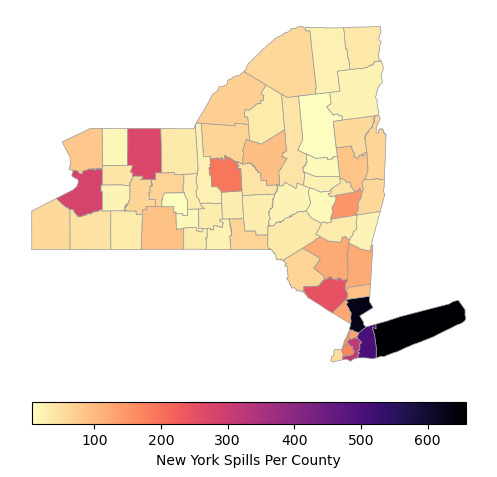

In [30]:
# Map
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
ny_counties.plot(
    ax=ax,
    column='n_spills',
    cmap='magma_r',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "New York Spills Per County",
        "orientation": "horizontal",
        "pad": 0.05
    }
)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Write a figure description for the map, including tha names of the top 3 counties with the most petroleum spills. If you need to do additional data analysis to include relevant information from the data, you may include additional code cells here.

This map shows the number of spills by county in New York State. The three counties with the most spills are Suffolk(657), Westchester(630), Nassau(503).

In [31]:
ny_counties = ny_counties.sort_values(by= 'n_spills', ascending=False)
ny_counties.head(3)

,statefp,countyfp,countyns,geoid,geoidfq,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
8,36,103,00974149,36103,0500000US36103,Suffolk,Suffolk County,06,H1,G4020,408,35620,35004,A,2359277313,3787417976,+40.9435540,-072.6922183,"POLYGON ((-71.80938 41.20323, -71.79115 41.184...",657
23,36,119,00974157,36119,0500000US36119,Westchester,Westchester County,06,H1,G4020,408,35620,35614,A,1115811940,179391718,+41.1526862,-073.7457526,"POLYGON ((-73.65762 40.98550, -73.65739 40.985...",630
20,36,059,00974128,36059,0500000US36059,Nassau,Nassau County,06,H1,G4020,408,35620,35004,A,736960644,437290665,+40.7296118,-073.5894144,"POLYGON ((-73.78019 40.82640, -73.77498 40.830...",503
